In [1]:
import numpy as np
from qiskit.providers.fake_provider import FakeManila
import qiskit.pulse as pulse

from casq.pulse_simulator import PulseSimulator
from casq.gates.gaussian_pulse_gate import GaussianPulseGate
from casq.common.plotting import plot, plot_bloch, plot_signal, LineStyle, LineType

%matplotlib inline


In [48]:
from qiskit.providers.fake_provider import FakeAlmaden
backend = FakeAlmaden()
config = backend.configuration()
props = backend.properties()
print(backend.control_channels)

dt = config.dt
qubit = 0
qubit_frequency = props.frequency(qubit)
duration = 256
sigma = 128

schedules = []

for amplitude in np.linspace(0., 1., 10):
    gpg = GaussianPulseGate(duration, amplitude, sigma)
    with pulse.build() as schedule:
        with pulse.align_sequential():
            gpg.instruction(qubit)
            pulse.shift_phase(0.5, pulse.DriveChannel(qubit))
            pulse.shift_frequency(0.1, pulse.DriveChannel(qubit))
            gpg.instruction(qubit)
            pulse.acquire(duration=1, qubit_or_channel=qubit, register=pulse.MemorySlot(qubit))

    schedules.append(schedule)

schedules[5].draw()


AttributeError: 'FakeAlmaden' object has no attribute 'control_channels'

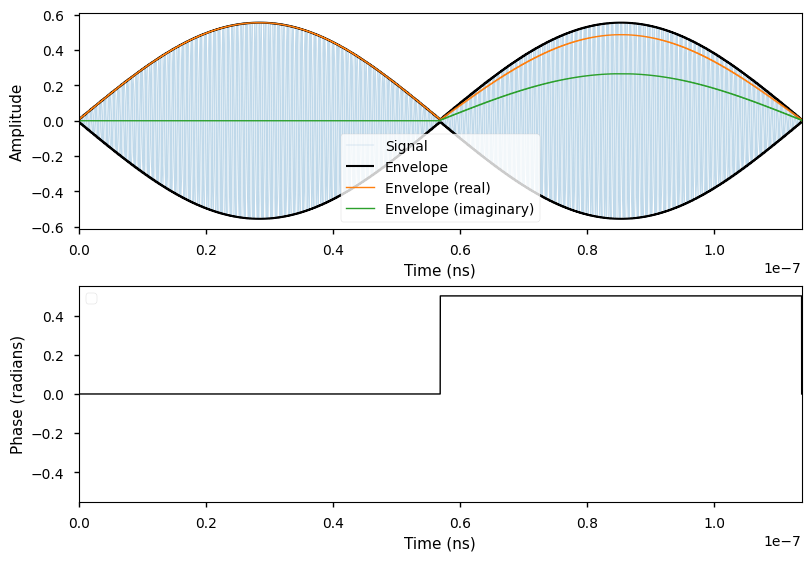

In [19]:
fig = plot_signal(schedules[5], dt, "d0", qubit_frequency, 2*duration*dt)


In [7]:
dim = 3

v0 = 4.86e9
anharm0 = -0.32e9
r0 = 0.22e9

v1 = 4.97e9
anharm1 = -0.32e9
r1 = 0.26e9

J = 0.002e9

a = np.diag(np.sqrt(np.arange(1, dim)), 1)
adag = np.diag(np.sqrt(np.arange(1, dim)), -1)
N = np.diag(np.arange(dim))

ident = np.eye(dim, dtype=complex)
full_ident = np.eye(dim**2, dtype=complex)

N0 = np.kron(ident, N)
N1 = np.kron(N, ident)

a0 = np.kron(ident, a)
a1 = np.kron(a, ident)

a0dag = np.kron(ident, adag)
a1dag = np.kron(adag, ident)


static_ham0 = 2 * np.pi * v0 * N0 + np.pi * anharm0 * N0 * (N0 - full_ident)
static_ham1 = 2 * np.pi * v1 * N1 + np.pi * anharm1 * N1 * (N1 - full_ident)

static_ham_full = static_ham0 + static_ham1 + 2 * np.pi * J * ((a0 + a0dag) @ (a1 + a1dag))

drive_op0 = 2 * np.pi * r0 * (a0 + a0dag)
drive_op1 = 2 * np.pi * r1 * (a1 + a1dag)

In [8]:
from qiskit_dynamics import Solver

# build solver
dt = 1/4.5e9

solver = Solver(
    static_hamiltonian=static_ham_full,
    hamiltonian_operators=[drive_op0, drive_op1, drive_op0, drive_op1],
    rotating_frame=static_ham_full,
    hamiltonian_channels=["d0", "d1", "u0", "u1"],
    channel_carrier_freqs={"d0": v0, "d1": v1, "u0": v1, "u1": v0},
    dt=dt,
)

In [4]:
simulator = PulseSimulator(backend, [0])
solution = simulator.run(schedules)


2023-06-18 18:42:26.270 | DEBUG    | casq.pulse_simulator:run:103 - t_span = [[0.0, 1.1377777777777777e-07], [0.0, 1.1377777777777777e-07], [0.0, 1.1377777777777777e-07], [0.0, 1.1377777777777777e-07], [0.0, 1.1377777777777777e-07], [0.0, 1.1377777777777777e-07], [0.0, 1.1377777777777777e-07], [0.0, 1.1377777777777777e-07], [0.0, 1.1377777777777777e-07], [0.0, 1.1377777777777777e-07]]
2023-06-18 18:42:26.271 | DEBUG    | casq.pulse_simulator:run:105 - t_eval = [0.00000000e+00 1.14927048e-09 2.29854097e-09 3.44781145e-09
 4.59708193e-09 5.74635241e-09 6.89562290e-09 8.04489338e-09
 9.19416386e-09 1.03434343e-08 1.14927048e-08 1.26419753e-08
 1.37912458e-08 1.49405163e-08 1.60897868e-08 1.72390572e-08
 1.83883277e-08 1.95375982e-08 2.06868687e-08 2.18361392e-08
 2.29854097e-08 2.41346801e-08 2.52839506e-08 2.64332211e-08
 2.75824916e-08 2.87317621e-08 2.98810325e-08 3.10303030e-08
 3.21795735e-08 3.33288440e-08 3.44781145e-08 3.56273850e-08
 3.67766554e-08 3.79259259e-08 3.90751964e-08 4

In [5]:
print(solution[0])


  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 17
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 1.14927048e-09, 2.29854097e-09, 3.44781145e-09,
       4.59708193e-09, 5.74635241e-09, 6.89562290e-09, 8.04489338e-09,
       9.19416386e-09, 1.03434343e-08, 1.14927048e-08, 1.26419753e-08,
       1.37912458e-08, 1.49405163e-08, 1.60897868e-08, 1.72390572e-08,
       1.83883277e-08, 1.95375982e-08, 2.06868687e-08, 2.18361392e-08,
       2.29854097e-08, 2.41346801e-08, 2.52839506e-08, 2.64332211e-08,
       2.75824916e-08, 2.87317621e-08, 2.98810325e-08, 3.10303030e-08,
       3.21795735e-08, 3.33288440e-08, 3.44781145e-08, 3.56273850e-08,
       3.67766554e-08, 3.79259259e-08, 3.90751964e-08, 4.02244669e-08,
       4.13737374e-08, 4.25230079e-08, 4.36722783e-08, 4.48215488e-08,
       4.59708193e-08, 4.71200898e-08, 4.82693603e-08, 4.94186308e-08,
       5.05679012e-08, 5.17171717e-08, 5.

In [6]:
x = []
y = []
z = []
for sv in solution.y:
    xp, yp, zp = sv.data.real
    x.append(xp)
    y.append(yp)
    z.append(zp)
p0 = [sv.probabilities()[0] for sv in solution.y]
p1 = [sv.probabilities()[1] for sv in solution.y]


AttributeError: 'list' object has no attribute 'y'

In [ ]:
plot(data=[
        (solution.t, x, "$\\langle X \\rangle$", None, None),
        (solution.t, y, "$\\langle Y \\rangle$", None, None),
        (solution.t, z, "$\\langle Z \\rangle$", None, None),
    ],
    title="Bloch vector vs. $t$", xtitle="$t$",
    show_legend=True
)


In [ ]:
plot_bloch(x, y, z)


In [ ]:
plot(data=[
        (solution.t, p0, "Population in |0>", LineStyle(size=3), None),
        (solution.t, p1, "Population in |1>", LineStyle(size=3), None)
    ],
    vlines=[(T, LineStyle(type=LineType.DASHED, color="black"))],
    xlim=(0, 2*T), ylim=(0, 1.05),
    xtitle="Time (ns)", ytitle="Population",
    show_legend=True
)
